In [133]:
import cv2 as cv
import pandas as pd
import tensorflow as tf
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F
import random
import torch
import torch.nn as nn
import torch.optim as optim
import keras
from matplotlib import pyplot as plt

In [134]:
def normalization(df):
    df_min_max_scaled = df.copy() 
  
    for column in df_min_max_scaled.columns: 
        df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())     
    
    return df_min_max_scaled;

In [135]:
train = pd.read_csv("train.csv");
train["Sex"] = train["Sex"].apply(lambda x: 1 if x == "female" else 0);
train_f = train.drop(columns=["Survived"]);
train_l = train["Survived"];

In [136]:
display(train);

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,C148,C


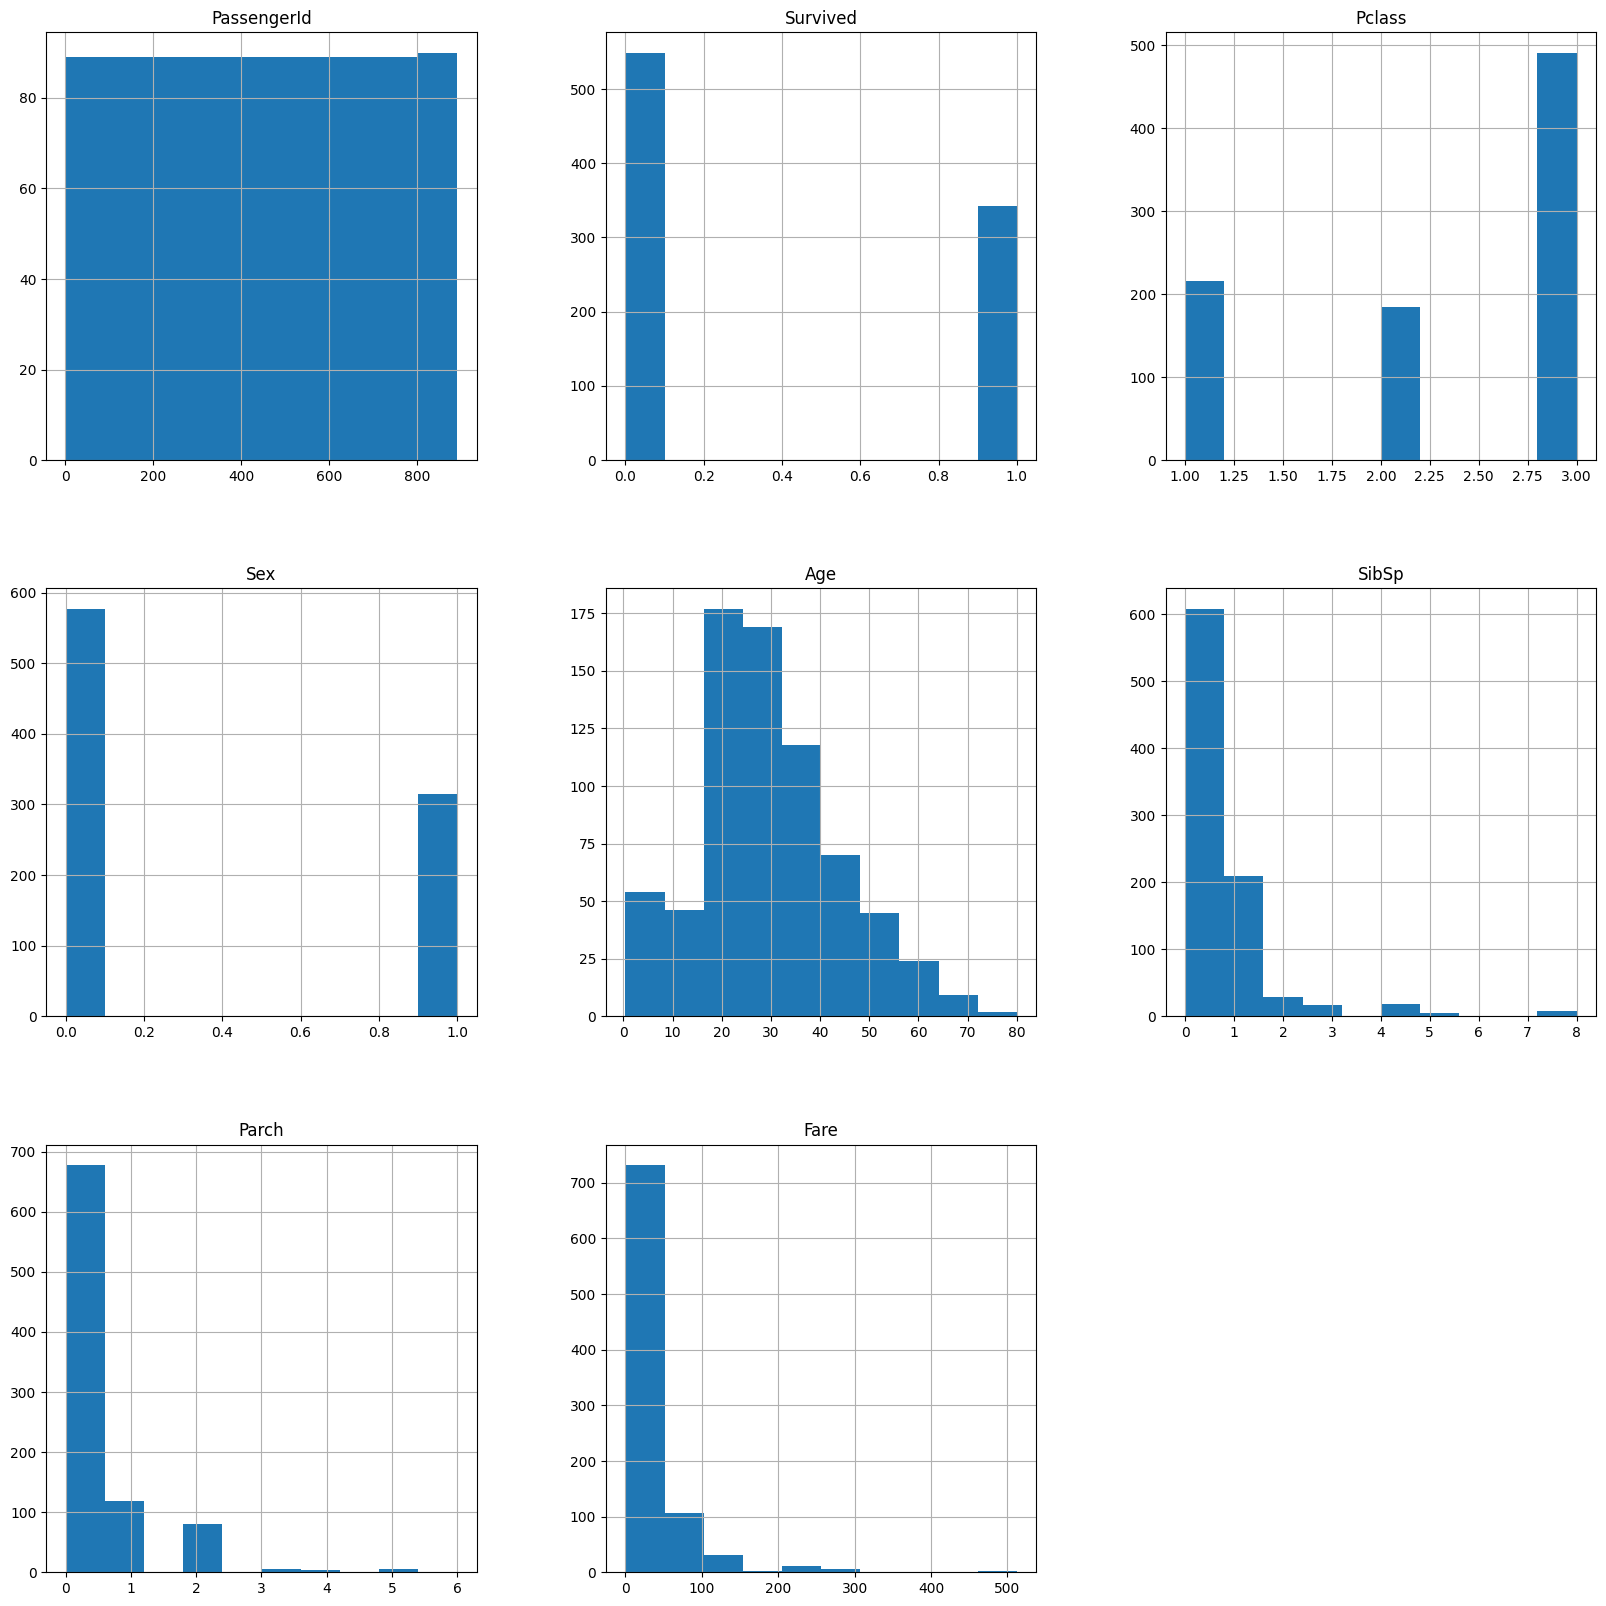

In [137]:
train.hist(figsize=(20, 20));

In [138]:
device = torch.device("mps");
print(device);

mps


In [139]:
model = nn.Sequential(
    nn.Linear(6, 48),
    nn.Sigmoid(),
    nn.Linear(48, 96),
    nn.Sigmoid(),
    nn.Linear(96, 48),
    nn.Sigmoid(),
    nn.Linear(48, 2)
)

model.to(device);

In [140]:
X = train_f[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]];
X["Pclass"].fillna(2, inplace=True);
X["Sex"].fillna(0, inplace=True);
X["Age"].fillna(29.65, inplace=True);
X["SibSp"].fillna(0, inplace=True);
X["Parch"].fillna(1, inplace=True);
X["Fare"].fillna((X["Fare"].mean()), inplace=True);

X = normalization(X);

X = X.to_numpy();
X_tensor = torch.tensor(X, dtype=torch.float32).to(device);
print(X_tensor)

tensor([[1.0000, 0.0000, 0.2712, 0.1250, 0.0000, 0.0142],
        [0.0000, 1.0000, 0.4722, 0.1250, 0.0000, 0.1391],
        [1.0000, 1.0000, 0.3214, 0.0000, 0.0000, 0.0155],
        ...,
        [1.0000, 1.0000, 0.3673, 0.1250, 0.3333, 0.0458],
        [0.0000, 0.0000, 0.3214, 0.0000, 0.0000, 0.0586],
        [1.0000, 0.0000, 0.3968, 0.0000, 0.0000, 0.0151]], device='mps:0')


/var/folders/tx/76w278b161bdwbkc9k2ktmp00000gp/T/ipykernel_17539/3634297136.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X["Pclass"].fillna(2, inplace=True);
/var/folders/tx/76w278b161bdwbkc9k2ktmp00000gp/T/ipykernel_17539/3634297136.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Pclass"].fillna(2, inplace=True);
/var/folders/tx

In [141]:
y = train_l;
y = y.to_numpy();

y_new = np.array([]);

for x in y:
    if(x == 0):
        y_new = np.append(y_new, 1);
        y_new = np.append(y_new, 0);
    else:
        y_new = np.append(y_new, 0);
        y_new = np.append(y_new, 1);

y_new = y_new.reshape((-1, 2));
y_tensor = torch.tensor(y_new, dtype=torch.float32).to(device);

print(y_tensor);

tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 0.],
        [0., 1.],
        [1., 0.]], device='mps:0')


In [142]:
loss_fn   = nn.L1Loss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.0000005)

n_epochs = 1000
batch_size = 10

for epoch in range(n_epochs):
    for i in range(0, len(X_tensor), batch_size):
        if(i % 300 == 0): 
            print(i / len(X_tensor) * 100, '% epoch', epoch);
            #for param in model.parameters():
            #    print(param.data)
        Xbatch = X_tensor[i:i+batch_size].to(device)
        #print(Xbatch.shape);
        y_pred = model(Xbatch).to(device);
        ybatch = y_tensor[i:i+batch_size].to(device);
        #print(y_pred);
        #print(y_tensor);
        #print("model.co: ", model.parameters());
        loss = loss_fn(y_pred, ybatch).to(device);
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

0.0 % epoch 0
33.670033670033675 % epoch 0
67.34006734006735 % epoch 0
Finished epoch 0, latest loss 0.49359530210494995
0.0 % epoch 1
33.670033670033675 % epoch 1
67.34006734006735 % epoch 1
Finished epoch 1, latest loss 0.49222782254219055
0.0 % epoch 2
33.670033670033675 % epoch 2
67.34006734006735 % epoch 2
Finished epoch 2, latest loss 0.4908662438392639
0.0 % epoch 3
33.670033670033675 % epoch 3
67.34006734006735 % epoch 3
Finished epoch 3, latest loss 0.4895070493221283
0.0 % epoch 4
33.670033670033675 % epoch 4
67.34006734006735 % epoch 4
Finished epoch 4, latest loss 0.4881492257118225
0.0 % epoch 5
33.670033670033675 % epoch 5
67.34006734006735 % epoch 5
Finished epoch 5, latest loss 0.48679232597351074
0.0 % epoch 6
33.670033670033675 % epoch 6
67.34006734006735 % epoch 6
Finished epoch 6, latest loss 0.4854360520839691
0.0 % epoch 7
33.670033670033675 % epoch 7
67.34006734006735 % epoch 7
Finished epoch 7, latest loss 0.48408031463623047
0.0 % epoch 8
33.670033670033675 % e

In [145]:
with torch.no_grad():
    y_pred = model(X_tensor).to(device);
print(y_pred);
print(y_tensor)
accuracy = (y_pred.round() == y)
print(f"Accuracy {accuracy}")

tensor([[ 9.9997e-01, -3.6314e-05],
        [ 9.9887e-01,  8.2706e-04],
        [ 9.9933e-01,  5.1134e-04],
        ...,
        [ 9.9957e-01,  5.2302e-04],
        [ 9.9969e-01,  2.2905e-04],
        [ 9.9998e-01,  3.5018e-06]], device='mps:0')
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 0.],
        [0., 1.],
        [1., 0.]], device='mps:0')
Accuracy False


In [147]:
test = pd.read_csv("test.csv");
test["Sex"] = test["Sex"].apply(lambda x: 1 if x == "female" else 0);

test = test[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]];
test["Pclass"].fillna(2, inplace=True);
test["Sex"].fillna(0, inplace=True);
test["Age"].fillna(29.65, inplace=True);
test["SibSp"].fillna(0, inplace=True);
test["Parch"].fillna(1, inplace=True);
test["Fare"].fillna((test["Fare"].mean()), inplace=True);

test = normalization(test);

arr = test.to_numpy();

print(arr);

X_test_tensor = torch.tensor(arr, dtype=torch.float32).to(device);

print(X_test_tensor);

print(model(X_test_tensor))

/var/folders/tx/76w278b161bdwbkc9k2ktmp00000gp/T/ipykernel_17539/4139711827.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test["Pclass"].fillna(2, inplace=True);
/var/folders/tx/76w278b161bdwbkc9k2ktmp00000gp/T/ipykernel_17539/4139711827.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

[[1.         0.         0.4527232  0.         0.         0.01528158]
 [1.         1.         0.61756561 0.125      0.         0.01366309]
 [0.5        0.         0.8153765  0.         0.         0.01890874]
 ...
 [1.         0.         0.50547277 0.         0.         0.01415106]
 [1.         0.         0.38876434 0.         0.         0.01571255]
 [1.         0.         0.38876434 0.125      0.11111111 0.0436405 ]]
tensor([[1.0000, 0.0000, 0.4527, 0.0000, 0.0000, 0.0153],
        [1.0000, 1.0000, 0.6176, 0.1250, 0.0000, 0.0137],
        [0.5000, 0.0000, 0.8154, 0.0000, 0.0000, 0.0189],
        ...,
        [1.0000, 0.0000, 0.5055, 0.0000, 0.0000, 0.0142],
        [1.0000, 0.0000, 0.3888, 0.0000, 0.0000, 0.0157],
        [1.0000, 0.0000, 0.3888, 0.1250, 0.1111, 0.0436]], device='mps:0')
tensor([[ 9.9997e-01,  1.4558e-05],
        [ 9.9919e-01,  5.4985e-04],
        [ 9.9969e-01,  1.9705e-04],
        [ 1.0000e+00, -4.1127e-06],
        [ 9.9939e-01,  5.0084e-04],
        [ 1.0000e+00, 

In [148]:
pd.set_option('display.max_columns', None)

mat = model(X_test_tensor).cpu().data.numpy();
print((mat));


ans = pd.DataFrame();

file = open("ans.csv", 'w');

for i in range(len(mat)):
    mx = mat[i].argmax();
    print(mx);
    file.write(str(i + 1) + ',' + str(mx) + "\n");
    #print("i: ", i, " mx:", mx)
    


[[ 9.99966502e-01  1.45584345e-05]
 [ 9.99193668e-01  5.49852848e-04]
 [ 9.99693513e-01  1.97045505e-04]
 [ 9.99995351e-01 -4.11272049e-06]
 [ 9.99387026e-01  5.00842929e-04]
 [ 1.00004613e+00 -3.73274088e-05]
 [ 9.99311805e-01  5.22948802e-04]
 [ 9.99904752e-01  1.07601285e-04]
 [ 9.99355674e-01  4.96603549e-04]
 [ 9.99913573e-01 -3.59266996e-05]
 [ 9.99985099e-01  2.10106373e-06]
 [ 9.99593973e-01  2.83777714e-04]
 [ 9.98930812e-01  8.07270408e-04]
 [ 9.99638677e-01  2.00048089e-04]
 [ 9.98824358e-01  8.43368471e-04]
 [ 9.99100685e-01  6.38440251e-04]
 [ 9.99807119e-01  1.27665699e-04]
 [ 1.00001884e+00 -2.08020210e-05]
 [ 9.99265075e-01  5.07697463e-04]
 [ 9.99257922e-01  5.55321574e-04]
 [ 9.99501944e-01  3.26178968e-04]
 [ 1.00017583e+00 -5.24967909e-05]
 [ 9.98956800e-01  7.86483288e-04]
 [ 9.99815941e-01  2.49929726e-04]
 [ 9.99132395e-01  1.01687014e-03]
 [ 9.99855042e-01  4.44948673e-05]
 [ 9.99095559e-01  7.96310604e-04]
 [ 1.00001299e+00 -1.69575214e-05]
 [ 9.99616385e-01  2